In [1]:
import numpy as np 
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns 

# Route Distribution in Matched CSV

In [2]:
# Sample data from `2023-04-01.routes.csv`
# flight_id,real_waypoints,pass_times,speeds,alts,real_full_waypoints,full_pass_times,full_speeds,full_alts
# 0200AFRAM650E,GMFO VIBAS BLN BINVA BASIM_84 ABRIX DIBES LFPQ LFPO,1680333942 1680335699 1680336119 1680336479 1680337679 1680338879 1680340979 1680342119 1680342539,0.0944 0.2169 0.2533 0.2208 0.2335 0.2351 0.2348 0.1015 0.0000,1044 11918 11895 11857 11750 11590 8016 1745 236,OJD _rKTz5NPa _IY6nwpxO VIBAS BLN BINVA BASIM_84 ABRIX DIBES _nupgHjcL _YOMHXtrL _ULWw9op1 LFPQ _3pV0F70F _Jygd1MRR LFPO,1680333942 1680333959 1680334739 1680335699 1680336119 1680336479 1680337679 1680338879 1680340979 1680341459 1680341639 1680341999 1680342119 1680342299 1680342479 1680342539,0.0944 0.0944 0.2215 0.2169 0.2533 0.2208 0.2335 0.2351 0.2348 0.1861 0.1966 0.1334 0.1015 0.0879 0.0663 0.0000,1044 1044 9891 11918 11895 11857 11750 11590 8016 3315 3307 2393 1745 1196 450 236

def od_extract(route: str):
    """
    Extract the origin and destination waypoint from a space-separated route string.
    Returns a tuple (origin, destination), or (None, None) if not extractable.

    Args:
        route (str): Space-separated waypoints (e.g., "GMFO VIBAS ... LFPO")

    Returns:
        tuple: (origin, destination)
    """

    if not isinstance(route, str):
        return (None, None)
    # Remove any leading/trailing whitespace and split by whitespace.
    waypoints = [w.strip() for w in route.strip().split() if w.strip()]
    if len(waypoints) < 2:
        # Can't extract both origin and destination
        if len(waypoints) == 1:
            return (waypoints[0], waypoints[0])
        else:
            return (None, None)

    return (waypoints[0], waypoints[-1])



# Route Statistics

In [5]:
ROUTES_DIR = '../matched_filtered_data'

def list_route_files(dir_path: str = ROUTES_DIR):
    import os

    route_files = []
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.endswith('.routes.csv'):
                route_files.append(os.path.join(root, file))
    return route_files


def count_od_pairs(route_files: list[str]):
    import pandas as pd 
    from tqdm import tqdm

    od_count_dicts = {} # {"origin-destination": count}

    for route_file in tqdm(route_files, desc="Processing route files"):
        # if route_file's filename starts with "._" then skip it
        if route_file.split('/')[-1].startswith('._'):
            continue
        # Correct usage: set description on tqdm iterator, not tqdm class
        df_route = pd.read_csv(route_file)
        for _, row in df_route.iterrows():
            route = row['real_waypoints']
            origin, destination = od_extract(route)
            od_pair = f"{origin}-{destination}"
            if od_pair in od_count_dicts:
                od_count_dicts[od_pair] += 1
            else:
                od_count_dicts[od_pair] = 1

    return od_count_dicts
    
counts = count_od_pairs(list_route_files())

Processing route files: 100%|██████████| 225/225 [02:06<00:00,  1.77it/s]


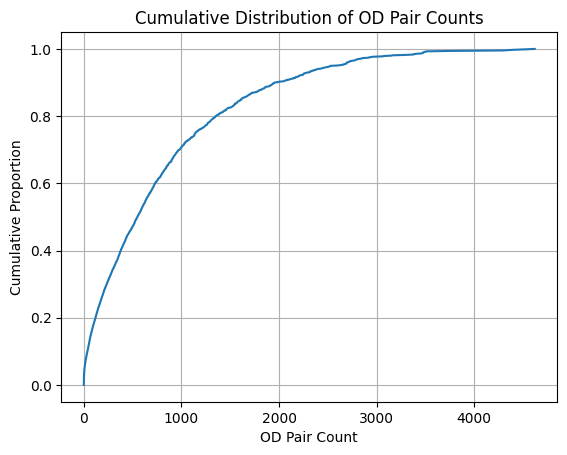

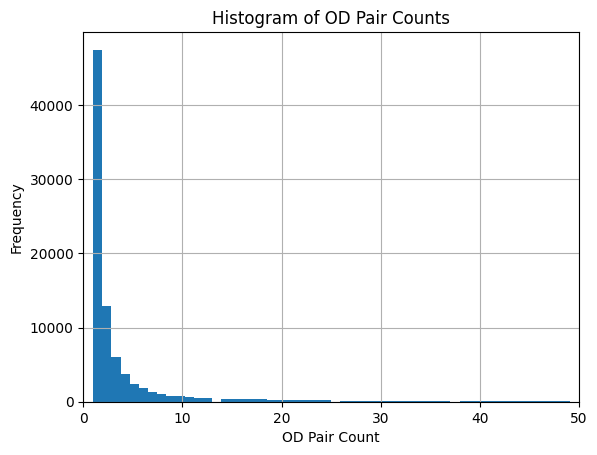

In [6]:
import pandas as pd
# Convert the count dicts to a pandas dataframe
df_counts = pd.DataFrame(list(counts.items()), columns=['od_pair', 'count'])

# Sort the dataframe by count in descending order
df_counts = df_counts.sort_values(by='count', ascending=False)

# Plot the cumulative distribution of the counts
# Plot the cumulative distribution of the counts
import numpy as np

counts_sorted = np.sort(df_counts['count'])
cumulative = np.cumsum(counts_sorted)
cumulative = cumulative / cumulative[-1]  # normalize to [0, 1]

plt.figure()
plt.plot(counts_sorted, cumulative)
plt.xlabel('OD Pair Count')
plt.ylabel('Cumulative Proportion')
plt.title('Cumulative Distribution of OD Pair Counts')
plt.grid(True)
plt.show()

# Plot the histogram of the counts
plt.figure()
plt.hist(df_counts['count'], bins=5000)
plt.xlim(0, 50)
plt.xlabel('OD Pair Count')
plt.ylabel('Frequency')
plt.title('Histogram of OD Pair Counts')
plt.grid(True)
plt.show()


# Create a structure for historical route access

In [12]:
# Create a folder of structured CSVs for rapid querying: 
# For example: LFXX.csv will contain all flights departing from France.

import os
from tqdm import tqdm 
from collections import defaultdict

# Create output directory
output_dir = '../matched_filtered_data_by_origin_region'
os.makedirs(output_dir, exist_ok=True)

# Dictionary to accumulate rows by origin prefix
origin_data = defaultdict(list)

# Read all route files
route_files = list_route_files()

print(f"Processing {len(route_files)} route files...")

for route_file in tqdm(route_files):
    if route_file.split('/')[-1].startswith('._'):
        print(f"Skipping {route_file} because it starts with '._'")
        continue
    df = pd.read_csv(route_file)
    
    # Group rows by origin prefix (first 2 characters of origin airport)
    for _, row in df.iterrows():
        route = row['real_waypoints']
        origin, destination = od_extract(route)
        if pd.notna(origin) and len(origin) >= 2:
            origin_prefix = origin[:2]
            origin_data[origin_prefix].append(row.to_dict())

# Write each origin prefix to its own CSV file
print(f"\nWriting {len(origin_data)} origin prefix files...")
for origin_prefix, rows in tqdm(origin_data.items()):
    output_file = os.path.join(output_dir, f'{origin_prefix}.csv')
    df_origin = pd.DataFrame(rows)
    df_origin.to_csv(output_file, index=False)

print(f"Done! Created {len(origin_data)} CSV files in {output_dir}")


Processing 225 route files...


100%|██████████| 225/225 [01:59<00:00,  1.88it/s]


Skipping ../matched_filtered_data/._2023-04-01.routes.csv because it starts with '._'

Writing 57 origin prefix files...


100%|██████████| 57/57 [04:09<00:00,  4.37s/it]

Done! Created 57 CSV files in ../matched_filtered_data_by_origin_region


In [ ]:
# Save sorted_counts to a csv file
df_counts.to_csv('sorted_counts.csv', index=False)

: 